<a href="https://colab.research.google.com/github/Yoon0527/AIFFEL_Going_Deeper/blob/main/%5BGD_13%5D_About_Detection(single_stage).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD-13] 멀리 있지만 괜찮아


## 13.1 Dlib 얼굴 인식의 문제점
지금까지 배운 Face Detection을 위한 방법은 Dlib 라이브러리를 이용해서 Face Landmark를 찾아내는 것이었다. 하지만 이 방법만으로는 충분하지 않았음.
> **Q1. Dlib 라이브러리를 이용해 Face Landmark를 찾아낼 때의 문제점은 무엇이었나요?**
>
> A1. 얼굴을 잘 못 찾는다.<br>
> A2. 동영상을 처리하기엔 너무 느리다.<br>
A3. 얼굴각도, 방향, 크기 등의 변화에 취약하다.<br>
A4. 그 외에도 많은 문제점을 발견할 수 있다.

작아지고 빨라지는 것이 중요한 이유는 우선 비대면 인증 수단으로 얼굴 인식이 보편적으로 사용되기 시작했다는 점을 들 수 있다. 얼굴 인식을 위해 딥러닝 서버 구동이 필요한 모델을 활용할 수 있을까?

서버로 이미지를 보낸 후 처리하는 방식은 **네트워크 비용 + 서버 비용 + 인터넷 속도**의 영향을 고려하지 않을 수 없다. 따라서 네트워크 상황과 무관하게 항상 동작해야 하는 핸드폰 인증 수단으로는 적합하지 않다. 그렇다면 edge device를 바로 이용하려면 어떻게 해야할까?

핸드폰에 모델을 올리려면 weight가 작은 모델이 관리에 유리하다. 하지만 일반적으로 작은 모델은 성능이 떨어지기 때문에 어떻게 보완할 수 있을지 고민이 시작된다.

국내 IT 대기업들도 관련 연구를 활발히 진행하고 있다.
* 카카오: https://tech.kakaoenterprise.com/63
* 네이버: https://github.com/clovaai/EXTD_Pytorch

Face detection에서 많은 시간이 드는 요소는 Sliding Window이다. 그러므로 Sliding window를 버려야 빨라진다. 따라서 2-stage 방식의 detection은 좋은 선택이 아니다.

또한 연산의 병렬화가 가능해야 한다. 컴퓨터의 GPU에서는 병렬화가 가능하지만 핸드폰에서도 병렬화가 가능한지에 대해 생각해보면, 크게 안드로이드와 아이폰의 경우로 나누어 생각해볼 수 있다.

안드로이드에서는 MLKit, 아이폰에서는 CoreML이라는 라이브러리를 통해 병렬화를 할 수 있다. 하지만 제한이 많기 때문에 TFLite라는 도구를 이용해 훈련된 모델을 이용하기도 한다.

위 방법으로도 해결이 안되면 어렵더라도 다른 방법을 생각해봐야 한다. 우선 직접 병렬 프로그래밍 라이브러리를 만들어볼 수 있겠지만, 난이도가 너무 높다. 비교적 쉬운 방법으로는 SIMD 병렬 프로그래밍이나 OpenCL, Android: Open GLES 등 병렬화 도구를 사용하는 방법이 있다.

하지만 무엇보다도 적은 파라미터 수로도 정확한 성능을 가지는 모델을 설계하는 게 중요할 것이다.
****


## 13.2 Single Stage Object Detection
2-stage Detector는 물체가 존재하는 bounding box를 먼저 찾은(localization) 후에 bounding box를 분류(classification)하는 두 가지 과정을 순차적으로 거쳤기 때문에 속도가 느렸다.

반면 single stage detector는 localization과 classification을 동시에 수행하기 때문에 2단계를 거치는 2-stage detector보다는 속도가 빠르지만, 정확도가 낮다는 단점이 있다.

* 2-Stage Detector와 1-Stage Detector 모델 종류

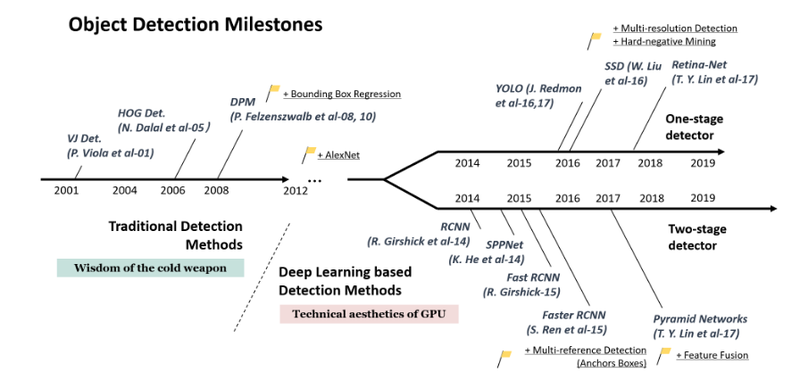

****
## 13.3 YOLO (1) YOLO v1의 등장
YOLO: You Only Look Once

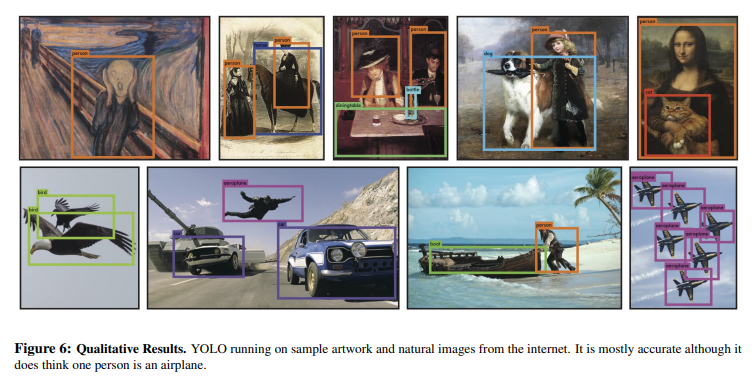

## 13.4 YOLO (2) YOLO v1의 원리
> 논문: https://arxiv.org/pdf/1506.02640.pdf

### YOLO의 특징
1. You Only Look Once
  * 전체 이미지를 보는 횟수가 1회라는 것을 의미한다. YOLO는 클래스에 대한 정보와 주변 정보까지 한 번에 학습하고 처리한다. 따라서 배경 오류가 적고 일반화 성능이 좋다.

2. Unified
  * Localization과 Classification을 동시에 수행한다.(single stage) YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능하다.

3. Real-Time
  * 기본적인 YOLO 모델로는 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다.(참고로 Fast R-CNN은 0.5FPS, DPM은 30FPS의 성능을 가지고 있다.) 따라서 스트리밍 비디오에서도 실시간으로 객체를 detection할 수 있다.

이 외에도 object detection을 회귀 문제로 관점을 전환했고, 여러 도메인에서 object detection이 가능하다는 특징이 있다.
****
### RCNN과 YOLO

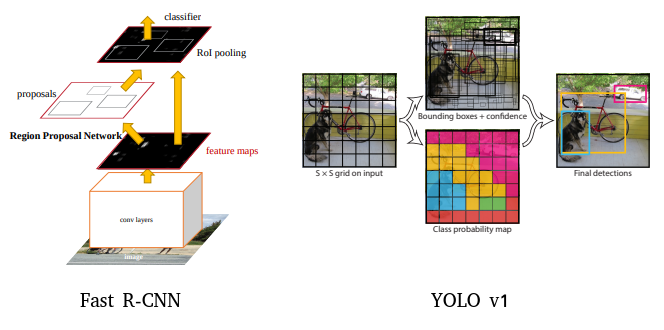

RCNN(2-stage detector)와 YOLO의 차이는
* RCNN 계열의 가정: 객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다. -> Region Proposal Network(RPN)
* YOLO v1의 가정: 이미지 내의 작은 영역을 나누면 그 곳에 객체가 있을 수 있다. -> grid 내에 객체가 존재한다.

따라서 YOLO v1에서 grid는 고정되고, **각 grid 안에 객체가 있을 확률**이 중요하게 된다.

> **Q2. YOLO v1에서 입력 이미지 크기가 448x448이고 출력 feature map이 7x7일 경우, 한 개의 출력 grid box(1x1 크기)가 의미하는 사이즈는 얼마일까요?**
>
> A. 448 / 7 = 64이므로 grid box 사이즈는 64x64이다.
****
### YOLO의 grid cell

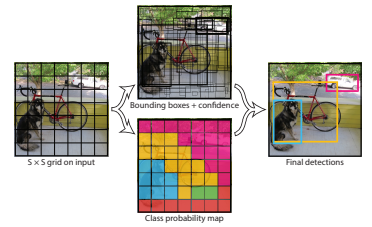

YOLO는 이미지를 S x S grid로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다.

논문에서는 입력 이미지를 7x7 grid로 나누고, 각 grid cell마다 예측하는 bound box(bbox)를 2개, 총 클래스의 수는 20으로 정했다.

각 grid cell은 bounding box와 c개의 class 확률을 예측한다.

각 bounding box(B)는 x, y, w, h, confidence score를 예측한다. x, y는 bbox의 중심 좌표이고 w와 h는 너비와 높이이다. 주의할 점은 w와 h는 입력 이미지를 bbox의 너비와 높이를 나눠서 normalize한 값으로 0과 1사이의 값을 가진다는 것이다.

confidence score는 box가 객체를 포함하고 있는지를 모델이 얼마나 자신 있는지, 그리고 박스가 예측하는 것이 얼마나 정확한지를 보여준다.

만약 grid cell이 객체를 포함하지 않으면 confidence score는 0이다. grid cell이 객체를 정확히 포함하고 있다면 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는 것이 좋다.

c개의 조건부 클래스 확률 P는 grid cell이 사물을 포함할 때 bbox 안의 객체가 i번째 클래스에 속할 확률이다. bounding box의 개수와 상관 없이 각 grid cell의 확률만 예측한다.

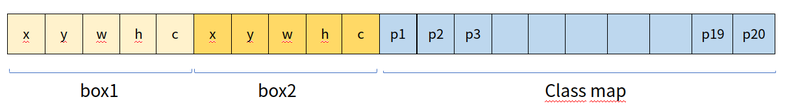

> **Q3. 1개의 7x7 grid 당 2개의 bounidng box(BBox) 와 20개 클래스를 예측하는 YOLO 를 만들고 싶은 경우, output tensor의 크기와 이를 flatten했을 때의 크기는 무엇인가요?**
>
> A. output tensor의 크기는 7 x 7 x (5 x 2 + 20)이며, 이를 flatten하면 1470이다.

위 이미지에서는 자전거를 포함하는 grid가 많다. 이런 경우는 해당 grid의 bbox가 모두 자전거라고 예측할까? 학습이 잘 된 경우는 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡는다. 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제가 생긴다.

이 때는 NMS(Non-Maximum Suppression)와 같은 기법을 이용한다. 비-최대 억제라고도 불리는 NMS 기법은 object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하는 기법이다.

* NMS의 알고리즘
1. 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬한다. confidence score가 특정 threshold를 넘지 않는 것은 제거한다.
2. 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거한다. 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.
3. 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환한다.
4. 각 클래스에 대해 위의 과정을 반복한다.

NMS 알고리즘을 적용하면 아래의 그림과 같이 겹쳐 있는 bounding box 중 정확한 bounding box만 표시된다.

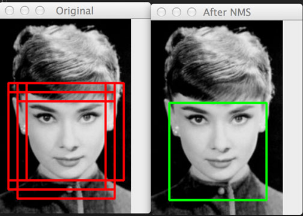

YOLO의 목표는 grid에 포함되는 객체를 잘 잡아내는 것이다. 즉, grid cell에 속하는 객체를 검출할 책임이 있는 것인데, 따라서 1개 grid에 귀속된 bbox 정보(x, y, w, h)의 학습 목표는 bbox의 ground truth와 최대한 동일하도록 학습되는 것이다. 학습 목표가 제대로 이루어졌는지를 확인하려면 객체 인식 모델의 성능 평가 도구인 IoU(Intersection over Union)를 사용한다.

> IoU의 개념: https://ballentain.tistory.com/12
***
### YOLO의 네트워크 구조
YOLO의 네트워크 구조는 아래 그림과 같이 24개의 Conv 레이어와 2개의 Fully connected layer로 구성되어 있다.

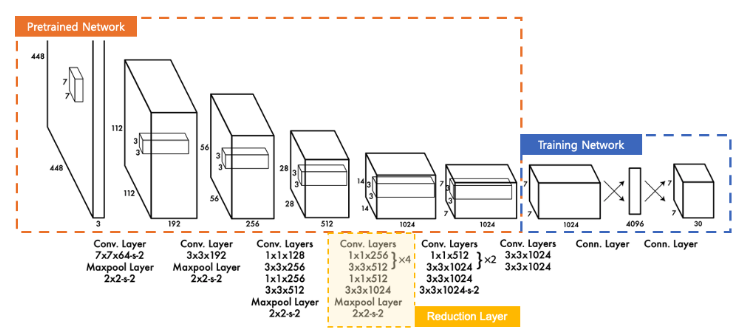

모델 구조의 앞부분(pretrained)은 ImageNet의 1000개 클래스 데이터셋을 가지고 사전학습한 GoogLeNet 모델이다. 사전학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fully-connected 레이어를 사용하였다. 그러나 GoogLeNet의 Inception 모듈 대신 1x1 reduction 레이어를 사용해 연산량을 감소시켰다.

detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC 레이어를 추가하였고, PASCAL VOC 데이터셋으로 fine-tuning하였다. fine-grained 이미지를 얻기 위해 원래의 224x224 이미지의 2배인 448x448 이미지를 사용했다고 한다.

마지막 레이어는 Class 확률과 bbox 좌표를 학습하고 예측하여 S x S x(B*5+c)크기의 텐서로 예측값이 출력된다.

### YOLO의 Inference 과정

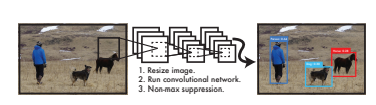

Inference를 할 때는 조건부 클래스 확률 P(Class|Object)를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class-specific confidence score)를 얻을 수 있다. 각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는지를 보여준다.

이 과정을 모든 bbox에서 시행하면, 한 이미지에서 예측한 클래스별 confidence score의 개수는 7 * 7 * 2 = 98개이다. 이 98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS를 하여 object에 대한 class와 bounding box location을 결정할 수 있다.

## 13.5 YOLO (3) YOLO v1의 성능


### YOLO v1의 loss 함수
YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며, 두 loss 모두 SSE(sun-square error)를 기반으로 한다. 그런데 SSE는 이 두 loss를 동일하게 가중치를 준다. 이런 상황은 이상적이 아니다. 뿐만 아니라 이미지 내 대부분의 grid cell에 객체가 없을 경우가 일반적인데, 이런 경우에는 confidence score가 0에 가깝게 된다. 이는 모델의 불균형을 초래한다.

이런 문제를 해결하기 위해 bbox의 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 값소시켰다. 이를 위해 λcoord와 λnoobj라는 두 개의 하이퍼파라미터를 사용했다.

뿐만 아니라 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산한다. 그러나 작은 bbox가 큰 bbox보다 조그마한 위치 변화에도 더 민감하다. 이를 개선하기 위해 bbox 너비와 높이에 square root를 취해주었다.

* YOLO의 loss 함수

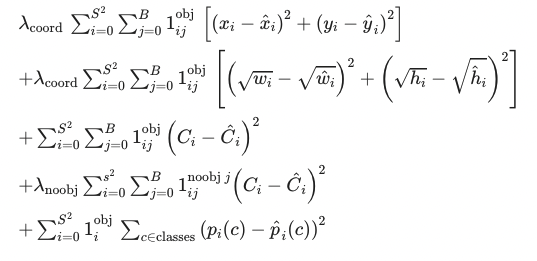

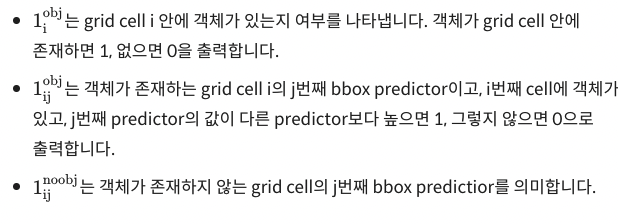

loss 함수를 하나씩 살펴보면 아래와 같다
* 첫번째 항 ~ 세번째 항: 객체가 존재하는 grid cell i의 bbox predictor j에 대해
  * 첫번째 항: x와 y의 loss 계산
  * 두번째 항: 너비와 높이의 loss 계산(제곱근을 취한 SSE)
  * 세번째 항: confidence score의 loss 계산

* 네 번째 항: 객체가 존재하지 않는 grid cell i의 bbox predictor j에 대해 confidence score의 loss 계산(객체가 없을 때의 패널티)
* 다섯번째 항: 객체가 존재하는 grid cell i에 대해 조건부 클래스 확률의 loss 계산

***
### YOLO의 성능

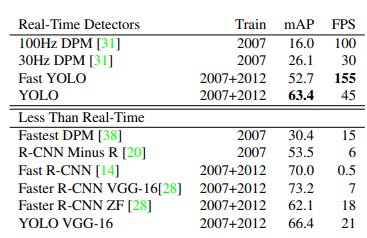

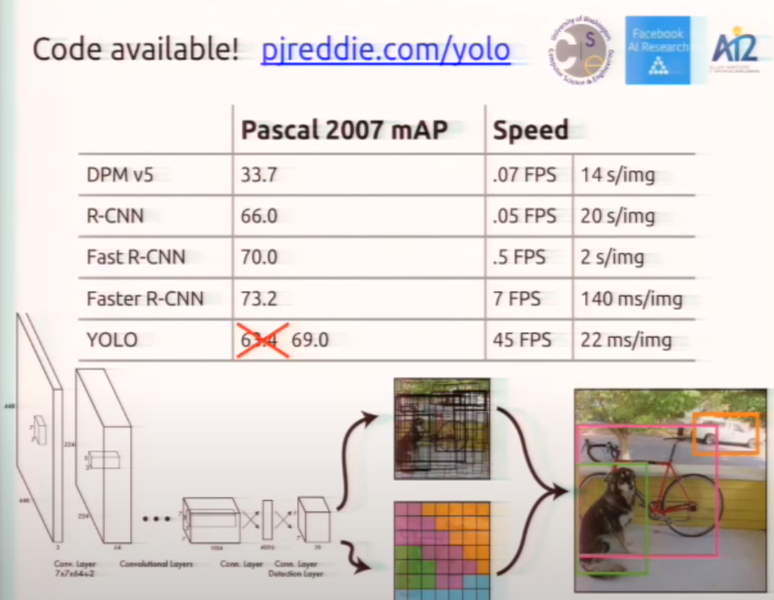

arXiv 논문 발표에서는 mAP가 63.4였지만 CVPR 2016 발표때는 69.0으로 모델의 성능을 향상되어 발표되었다. 즉 YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구였다.
***
### YOLO v1의 단점
우선 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러 개의 객체를 예측하기 어려웠다. 특히 새 떼와 같이 그룹으로 나타나는 작은 object에 대해 제대로 예측하지 못했다.

또한 bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되기도 했다. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확했다.

마지막으로 loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미쳤다. 그래서 2017년 YOLO v2가 나오게 된다.

## YOLO (4) YOLO v2
* YOLO의 목적
  * Make in better
  * Do it faster
  * Makes us stronger

### Make it better
Better은 정확도를 올리기 위한 방법이다. 이전 YOLO v1에서 낮은 성능으로 보였던 localization과 recall을 높이면서도 여전히 모델을 단순하게 만들고 속도도 빠르게 하려고 하였다.

이를 위해 사용한 방법으로, 
1. Batch Normalization
2. High Resolution Classifier
3. Convolutional with Anchor boxes
4. Dimension Clusters
5. Direct location prediction
6. Fine-Grained Features
7. Multi-Scale Training

등의 방법을 사용하였다. 각 방법을 사용했을 때의 결과는 아래 표로 정리되어 있다.

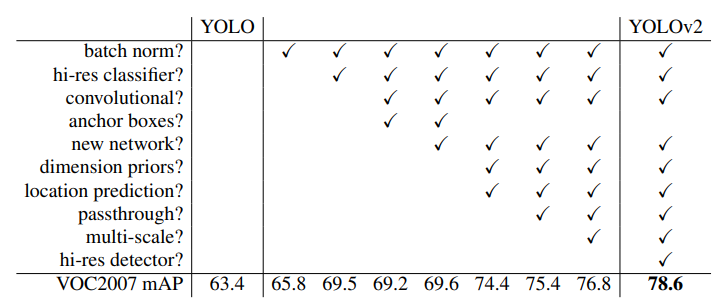

* Batch Normalization

  * 모든 conv 레이어에 batch normalizaion을 사용하였고, dropout은 제거하였습니다. 이로써 mAP에서 2% 이상의 성능 개선을 하였습니다.

* High Resolution Classifier

  * YOLO v1에서 ImageNet의 224 x 224 이미지를 학습하고, detection에서 448 x 448 이미지를 사용했던 것과 달리 YOLO v2에서는 처음부터 448 x 448의 해상도로 학습하였습니다. 이로써 mAP에서 4% 정도의 성능 개선을 이루었습니다.

* Convolutional With Anchor Boxes

  * bounding box를 예측하기 위해 YOLO v1의 Fully connected 레이어를 제거한 후 Fully Convolutional Network를 사용하였고, anchor box들을 사용해 bounding box를 예측하였습니다.
 
 * 또한 1개의 중앙점을 갖는 13 x 13(홀수 x 홀수)의 출력 feature map을 만들도록 입력 이미지의 크기를 448 x 448에서 416 x 416로 줄였습니다. 이는 대부분의 객체가 이미지의 중앙에 있는데, 중앙에 위치한 객체의 경우는 중앙점이 하나일 경우에 더 잘 예측할 것이라는 예상 때문이었습니다.

  * 따라서 YOLO v2는 13 * 13 * 5개의 bounding box를 예측합니다.

  * 그 결과 mAP는 69.5에서 69.2로 떨어지지만 recall은 81%에서 88%로 증가였습니다.

* Dimension Cluster

  * Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정을 했습니다. 그러나.YOLO v2는 k-means clustering을 적용해 최적의 anchor box를 결정하였습니다.

  * 하지만 유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 IoU 개념을 distance metric으로 사용해 더 좋은 anchor box를 얻을 수 있었어요. 그 이유는 ground truth box와 유사한, 즉 IoU가 높은 anchor box를 찾기 위해서였습니다.

  * 클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 YOLO v2는 최종적으로 5개의 anchor box를 사용했습니다.

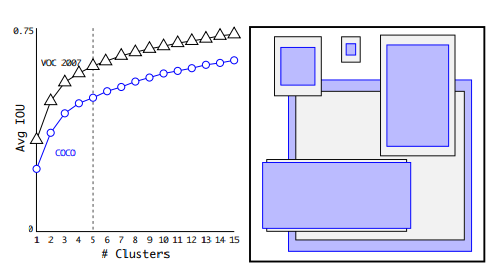
